In [0]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from preprocessor import *
from featuregenerator import *
from dmcscore import score

import xgboost as xgb
from sklearn.metrics import mean_squared_error, mean_absolute_error, classification_report


from google.colab import drive
drive.mount('/content/drive')

pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [0]:
infos_df = pd.read_csv('/content/drive/My Drive/DMC2020/infos.csv', sep='|')
items_df = pd.read_csv('/content/drive/My Drive/DMC2020/items.csv', sep='|')
orders_df = pd.read_csv('/content/drive/My Drive/DMC2020/orders.csv', sep='|')

pp = PreProcessor()
fg = FeatureGenerator()

evaluation = pd.DataFrame(columns=['split','model','pred-score abs','overfee-score abs', 'dmc-score abs', 'max-score abs','dmc-score %', 'sum order','sum_prediction','runtime','rmse', 'mae', 'hyperparameters', 'features importance'])

In [0]:
df_item_per_biweek = pp.create_item_per_biweek(orders_df,items_df,infos_df)
df_item_per_biweek = pp.create_classification(df_item_per_biweek)
#df_item_per_biweek = pp.create_peak(df_item_per_biweek)
df_item_per_biweek = fg.create_max(df_item_per_biweek,13)
df_item_per_biweek = fg.create_percentile_order_count(df_item_per_biweek,13)
df_item_per_biweek = fg.feature_agg_order_per_time(df_item_per_biweek,['percentile_order_count'],13)
col = list(df_item_per_biweek.columns[13:])
df_item_per_biweek = fg.create_features_to_lag(df_item_per_biweek, col+['order','cl_order'],[1,2])
df_item_per_biweek = df_item_per_biweek.drop(columns=columns, axis=1)
df_item_per_biweek = fg.one_hot_encoding(df_item_per_biweek,['percentile_order_count'])

In [0]:
X_train, X_test, y_train, y_test = pp.train_test_split_cl(df_item_per_biweek, 13)

In [0]:
model = xgb.XGBClassifier(
    max_depth=8,
    n_estimators=1000,
    min_child_weight=300, 
    colsample_bytree=0.8, 
    subsample=0.8, 
    eta=0.3,    
    seed=99)

model.fit(
    X_train.drop(columns=['biweek','itemID'], axis=1), 
    y_train,
    #eval_metric = 'auc',
    eval_set=[(X_train.drop(columns=['biweek','itemID'], axis=1),y_train), (X_test.drop(columns=['biweek','itemID'], axis=1), y_test)], 
    verbose=True, 
    early_stopping_rounds = 10)

[0]	validation_0-error:0.189262	validation_1-error:0.319698
Multiple eval metrics have been passed: 'validation_1-error' will be used for early stopping.

Will train until validation_1-error hasn't improved in 10 rounds.
[1]	validation_0-error:0.189262	validation_1-error:0.312243
[2]	validation_0-error:0.189262	validation_1-error:0.317595
[3]	validation_0-error:0.189278	validation_1-error:0.314441
[4]	validation_0-error:0.189175	validation_1-error:0.31339
[5]	validation_0-error:0.18931	validation_1-error:0.313008
[6]	validation_0-error:0.189214	validation_1-error:0.312721
[7]	validation_0-error:0.189047	validation_1-error:0.31014
[8]	validation_0-error:0.189063	validation_1-error:0.311096
[9]	validation_0-error:0.188729	validation_1-error:0.310905
[10]	validation_0-error:0.188657	validation_1-error:0.311383
[11]	validation_0-error:0.188784	validation_1-error:0.312625
[12]	validation_0-error:0.188394	validation_1-error:0.30928
[13]	validation_0-error:0.188171	validation_1-error:0.309663

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=0.8, eta=0.3, gamma=0,
              learning_rate=0.1, max_delta_step=0, max_depth=8,
              min_child_weight=300, missing=None, n_estimators=1000, n_jobs=1,
              nthread=None, objective='binary:logistic', random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=99,
              silent=None, subsample=0.8, verbosity=1)

In [0]:
print(classification_report(y_test,model.predict(X_test.drop(columns=['biweek','itemID'], axis=1))))

              precision    recall  f1-score   support

           0       0.70      0.77      0.73      5781
           1       0.68      0.59      0.63      4682

    accuracy                           0.69     10463
   macro avg       0.69      0.68      0.68     10463
weighted avg       0.69      0.69      0.69     10463



In [0]:
df_item_per_biweek['cl_order'][df_item_per_biweek['biweek']==13] = model.predict(X_test.drop(columns=['biweek','itemID'], axis=1))

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [0]:
X_train, X_test, y_train, y_test = pp.train_test_split(df_item_per_biweek, 13)

In [0]:
model = xgb.XGBRegressor(
    objective='reg:squarederror',
    max_depth=8,
    n_estimators=1000,
    min_child_weight=300, 
    colsample_bytree=0.8, 
    subsample=0.8, 
    eta=0.3,    
    seed=99)

model.fit(
    X_train.drop(columns=['biweek','itemID',], axis=1), 
    (y_train),
    #eval_metric = 'mae',
    eval_set=[(X_train.drop(columns=['biweek','itemID'], axis=1),(y_train)), (X_test.drop(columns=['biweek','itemID'], axis=1), (y_test))], 
    verbose=True, 
    early_stopping_rounds = 10)

[0]	validation_0-rmse:101.527	validation_1-rmse:119.938
Multiple eval metrics have been passed: 'validation_1-rmse' will be used for early stopping.

Will train until validation_1-rmse hasn't improved in 10 rounds.
[1]	validation_0-rmse:98.7651	validation_1-rmse:119.105
[2]	validation_0-rmse:97.3411	validation_1-rmse:118.353
[3]	validation_0-rmse:95.1944	validation_1-rmse:117.895
[4]	validation_0-rmse:92.7531	validation_1-rmse:117.491
[5]	validation_0-rmse:91.8823	validation_1-rmse:117.233
[6]	validation_0-rmse:89.7941	validation_1-rmse:117.121
[7]	validation_0-rmse:88.2685	validation_1-rmse:116.987
[8]	validation_0-rmse:87.6907	validation_1-rmse:116.908
[9]	validation_0-rmse:86.7034	validation_1-rmse:116.913
[10]	validation_0-rmse:85.8177	validation_1-rmse:116.952
[11]	validation_0-rmse:84.7514	validation_1-rmse:117.059
[12]	validation_0-rmse:84.1586	validation_1-rmse:117.086
[13]	validation_0-rmse:83.3571	validation_1-rmse:117.282
[14]	validation_0-rmse:82.7921	validation_1-rmse:117.

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=0.8, eta=0.3, gamma=0,
             importance_type='gain', learning_rate=0.1, max_delta_step=0,
             max_depth=8, min_child_weight=300, missing=None, n_estimators=1000,
             n_jobs=1, nthread=None, objective='reg:squarederror',
             random_state=0, reg_alpha=0, reg_lambda=1, scale_pos_weight=1,
             seed=99, silent=None, subsample=0.8, verbosity=1)

In [0]:
def score_help (x,y,z):
  if x>y:
    return y*z
  else:
    return x*z-((y-x)*z*0.6)

y_pred = model.predict(X_test.drop(columns=['biweek','itemID'], axis=1))
score_df = X_test.copy()
score_df['order'] = (y_test)
score_df['prediction'] = (y_pred)
score_df['prediction'] = score_df['prediction'].round()
score_df['prediction'] = score_df['prediction'].apply(lambda x : 0 if x<0 else x)
score_df = pd.merge(score_df, infos_df[['itemID','simulationPrice']], on='itemID')
score_df['score'] = score_df.apply(lambda x: score_help(x['order'],x['prediction'],x['simulationPrice']), axis=1)
pred, overfee, maxscore = score( (y_pred), (y_test),infos_df['simulationPrice'].values)

feature_importances = pd.DataFrame({'col': X_test.drop(columns=['biweek','itemID'], axis=1).columns,'imp':model.feature_importances_})
feature_importances = feature_importances.sort_values(by='imp',ascending=False)

In [0]:
evaluation = evaluation.append(pd.Series( ((1),'xgbRegressor',pred,overfee,(pred-overfee),maxscore,((pred-overfee)/maxscore*100),score_df['order'].sum(),score_df['prediction'].sum(),0,np.sqrt(mean_squared_error(y_test,y_pred)), mean_absolute_error(y_test,y_pred),model.get_params,feature_importances), index=evaluation.columns), ignore_index=True)

In [0]:
evaluation

,split,model,pred-score abs,overfee-score abs,dmc-score abs,max-score abs,dmc-score %,sum order,sum_prediction,runtime,rmse,mae,hyperparameters,features importance
0,1,xgbRegressor,978667.056525,1.707108e+06,-728441.255942,7683293.24,-9.480847,298511.0,133911.0,0,116.908681,34.818081,<bound method XGBModel.get_params of XGBRegres...,...


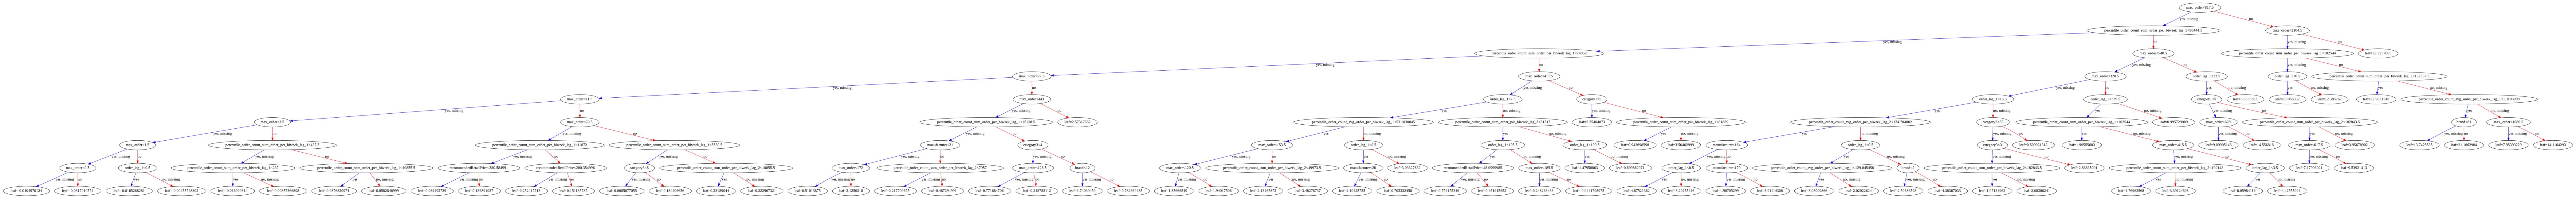

In [0]:
xgb.plot_tree(model, num_trees=2)
fig = plt.gcf()
fig.set_size_inches(150, 100)

In [0]:
feature_importances

,col,imp
7,cl_order,0.490818
20,percentile_order_count_4,0.194814
12,cl_order_lag_1,0.112532
8,max_order,0.046866
19,percentile_order_count_3,0.028676
16,cl_order_lag_2,0.025392
11,order_lag_1,0.025067
15,order_lag_2,0.019861
3,category1,0.014923
2,customerRating,0.007159


In [0]:
score_df.head(20)

,itemID,biweek,brand,manufacturer,customerRating,category1,category2,category3,recommendedRetailPrice,cl_order,max_order,percentile_order_count_sum_order_per_biweek_lag_1,percentile_order_count_avg_order_per_biweek_lag_1,order_lag_1,cl_order_lag_1,percentile_order_count_sum_order_per_biweek_lag_2,percentile_order_count_avg_order_per_biweek_lag_2,order_lag_2,cl_order_lag_2,percentile_order_count_1,percentile_order_count_2,percentile_order_count_3,percentile_order_count_4,order,prediction,simulationPrice,score
0,1,13,0,1,4.38,1,1,1,8.84,1,313.0,191067.0,116.362363,0.0,0.0,188732.0,116.645241,31.0,1.0,0,0,0,1,3.0,31.0,3.43,-47.334
1,2,13,0,2,3.00,1,2,1,16.92,0,3.0,783.0,2.175000,0.0,0.0,460.0,1.957447,3.0,1.0,1,0,0,0,0.0,0.0,9.15,0.000
2,3,13,0,3,5.00,1,3,1,15.89,1,95.0,66908.0,46.723464,1.0,1.0,63452.0,46.724595,0.0,0.0,0,0,1,0,140.0,25.0,14.04,351.000
3,4,13,0,2,4.44,1,2,1,40.17,0,43.0,16606.0,15.333333,0.0,0.0,15841.0,14.708449,5.0,1.0,0,1,0,0,145.0,1.0,14.10,14.100
4,5,13,0,2,2.33,1,1,1,17.04,1,127.0,66908.0,46.723464,2.0,1.0,63452.0,46.724595,3.0,1.0,0,0,1,0,1.0,15.0,7.48,-55.352
5,6,13,0,2,4.20,1,2,1,20.90,1,179.0,191067.0,116.362363,4.0,1.0,188732.0,116.645241,88.0,1.0,0,0,0,1,0.0,21.0,17.25,-217.350
6,7,13,0,3,4.00,1,3,1,26.40,0,1.0,783.0,2.175000,0.0,0.0,460.0,1.957447,0.0,0.0,1,0,0,0,1.0,0.0,34.39,0.000
7,8,13,0,4,5.00,1,1,1,14.13,0,100.0,66908.0,46.723464,0.0,0.0,63452.0,46.724595,0.0,0.0,0,0,1,0,1.0,3.0,4.98,-0.996
8,9,13,0,5,5.00,1,1,1,165.06,0,6.0,16606.0,15.333333,0.0,0.0,15841.0,14.708449,0.0,0.0,0,1,0,0,2.0,0.0,199.84,0.000
9,10,13,0,4,5.00,1,1,1,19.43,1,358.0,191067.0,116.362363,1.0,1.0,188732.0,116.645241,2.0,1.0,0,0,0,1,2.0,43.0,24.17,-546.242
